In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#load FastAi 
from fastai.metrics import error_rate
from fastai.vision import *
import re

In [0]:
#Fungi Data originaly found through a kaggle competition on Fungi classification
#Original Kaggle competition can be found here: https://github.com/visipedia/fgvcx_fungi_comp#data
#https://svampe.databasen.org/citation
#path refers to the training data, testing path to the validation se

#path = 'https://data.deic.dk/public.php?service=files&t=2fd47962a38e2a70570f3be027cea57f&download'



In [0]:
# Access Google Drive through Pydrive:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#Mount Google Drive where data is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Path to images
path = '/content/drive/My Drive/fungi/images'

In [0]:
#Define transformer
tfms = get_transforms(do_flip=False)

In [0]:
#Give some leeway for different blocksizes in images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
#Create Databunch with custom mask to accomodate file structure in dataset
data = (ImageList.from_folder(path)     #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()            #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=248)      #Data augmentation? -> use tfms with a size of 248
        .databunch())  


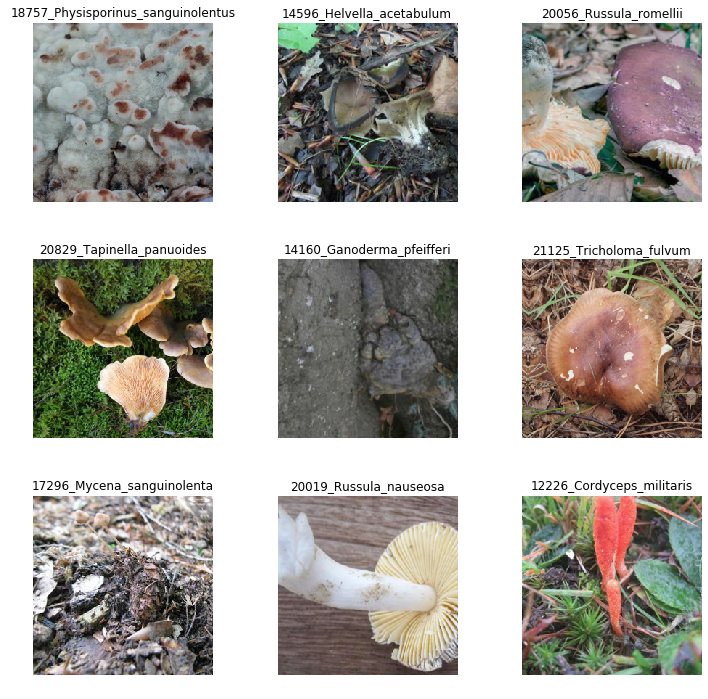

In [9]:
#Show the first three rows of data
data.show_batch(rows=3, figsize=(10,10))

In [10]:
#Check if Classes were created correctly
print(data.classes)
len(data.classes)

['10065_Agaricus_campestris', '10267_Amanita_submembranacea', '10526_Armillaria_mellea', '10676_Ascodichaena_rugosa', '10702_Ascotremella_faginea', '11054_Bolbitius_titubans', '11106_Botryobasidium_aureum', '11230_Calocera_cornea', '11284_Calyptella_campanula', '11285_Calyptella_capula', '11575_Chamaemyces_fracidus', '11696_Clavaria_fragilis', '11748_Clitocybe_alexandri', '11858_Collybia_cirrhata', '11867_Coltricia_perennis', '12226_Cordyceps_militaris', '12317_Cortinarius_foetens', '12352_Cortinarius_cinnabarinus', '12361_Cortinarius_caerulescens', '12486_Cortinarius_limonius', '12562_Cortinarius_psammocephalus', '12587_Cortinarius_rubellus', '12634_Cortinarius_subpurpurascens', '12648_Cortinarius_talus', '12663_Cortinarius_turgidus', '12665_Cortinarius_uliginosus f. uliginosus', '12785_Crepidotus_variabilis', '12805_Crinipellis_scabella', '12901_Cudoniella_acicularis', '13330_Cinereomyces_lindbladii', '13406_Dumontinia_tuberosa', '13738_Entoloma_rhodocalyx', '13770_Entoloma_sordidulu

133

In [12]:
#create learner model with pretrained resnet50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 160801838.07it/s]


In [13]:
#Let's see what the pretrained model does
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.179604,2.015384,0.480704,01:33
1,1.973809,1.421527,0.366629,01:32
2,1.338161,1.218281,0.317821,01:32
3,0.961746,1.177611,0.314415,01:33


In [14]:
#figure out what the model confuses
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

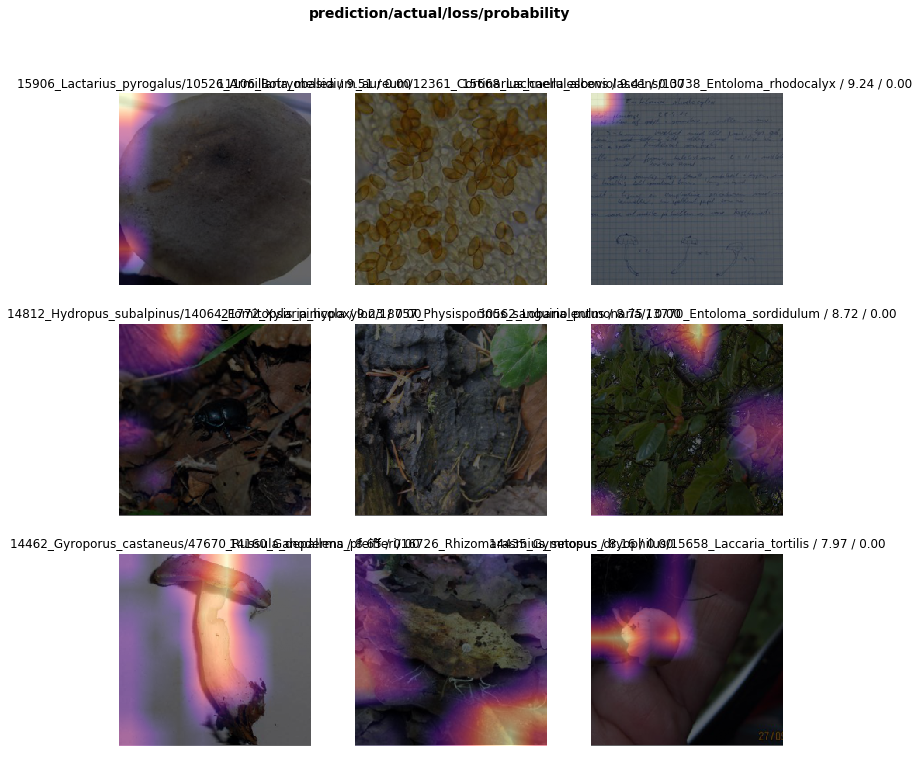

In [15]:
#plot the images it confuses
interp.plot_top_losses(9, figsize=(12,12))

In [16]:
#figure out what the model confuses the most
interp.most_confused(min_val=4)

[('14155_Ganoderma_adspersum', '14160_Ganoderma_pfeifferi', 14),
 ('14160_Ganoderma_pfeifferi', '14155_Ganoderma_adspersum', 9),
 ('14822_Hygrocybe_cantharellus', '14831_Hygrocybe_coccineocrenata', 4),
 ('14822_Hygrocybe_cantharellus', '14861_Gliophorus_psittacinus', 4),
 ('14855_Neohygrocybe_nitrata', '14881_Cuphophyllus_virgineus', 4),
 ('15651_Laccaria_proxima', '14435_Gymnopus_dryophilus', 4)]

In [0]:
#save pretrained model
learn.save('stage-1')

In [0]:
#unfreeze pretrained model
learn.unfreeze()

In [19]:
#let's see how new model does
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.470666,1.256587,0.339955,01:49


In [20]:
#find learning rates
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


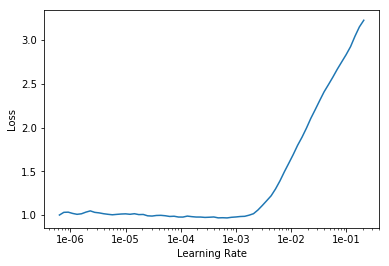

In [21]:
#plot learning rates
learn.recorder.plot()

In [22]:
#fit model with adjusted learning rates and more cycles
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.966935,1.216478,0.330874,01:48
1,0.899590,1.128217,0.296822,01:47
2,0.779746,1.057273,0.279796,01:47
3,0.669247,1.015352,0.272418,01:48
4,0.606494,0.985220,0.261067,01:47
5,0.532999,0.975202,0.258797,01:48
6,0.502889,0.969468,0.255959,01:48
7,0.502208,0.968909,0.255959,01:47


In [23]:
#see what the model did wrong this time
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

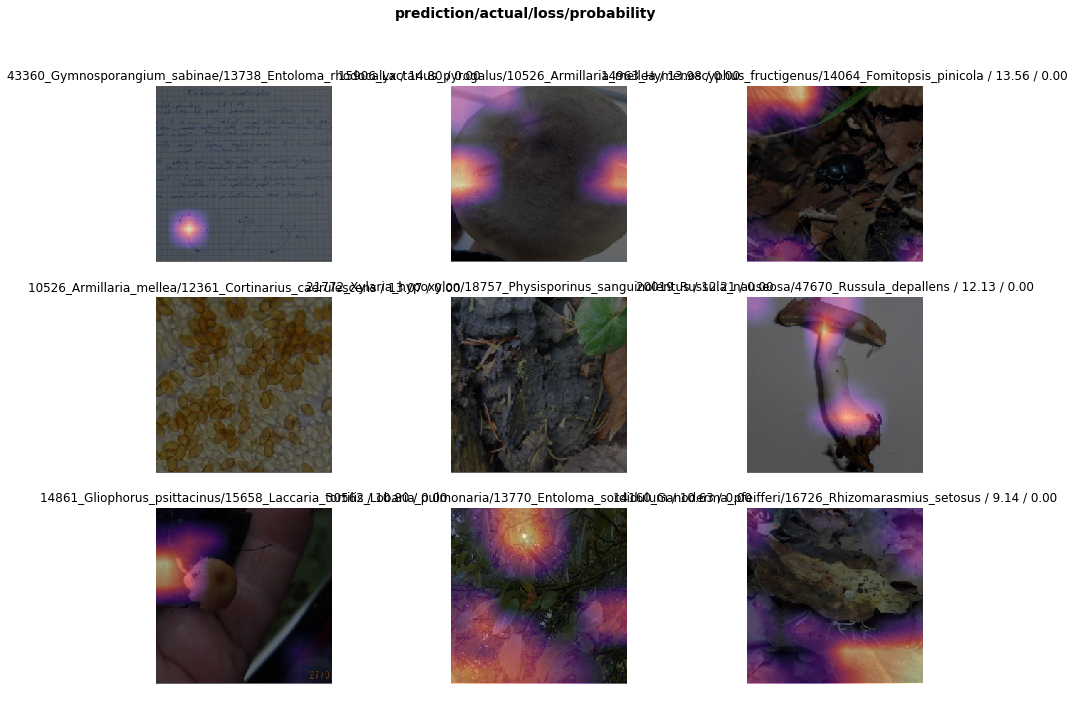

In [24]:
#plot images of model confusion
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
#save new model
learn.save('stage-2')